In [38]:
# Source: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from time import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [39]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Semon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
n_features = 4000
n_components = 6
n_top_words = 25
init = "nndsvda"

In [41]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, (n_components + 1) // 2, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [42]:
print("Loading dataset...")
t0 = time()
tweets_df = pd.read_csv('data/trump_prepared_tweets.csv', index_col='id')[['date', 'text', 'cleared_text']]
print("done in %0.3fs." % (time() - t0))
tweets_df.head()

Loading dataset...
done in 1.631s.


,date,text,cleared_text
id,,,
1234653427789070336,2020-03-03,I was thrilled to be back in the Great city of...,i was thrilled to be back in the great city of...
1218010753434820608,2020-01-17,RT @CBS_Herridge: READ: Letter to surveillance...,rt read letter to surveillance court obtained ...
1304875170860015616,2020-09-12,The Unsolicited Mail In Ballot Scam is a major...,the unsolicited mail in ballot scam is a major...
1218159531554897920,2020-01-17,RT @MZHemingway: Very friendly telling of even...,rt very friendly telling of events here about ...
1217962723234983936,2020-01-17,RT @WhiteHouse: President @realDonaldTrump ann...,rt president announced historic steps to prote...


In [43]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words=stop_words
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(tweets_df.cleared_text)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words=stop_words
)
t0 = time()
tf = tf_vectorizer.fit_transform(tweets_df.cleared_text)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 0.431s.
Extracting tf features for LDA...
done in 0.399s.


Fitting the NMF model (Frobenius norm) with tf-idf features, n_features=4000...
done in 0.327s.


C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


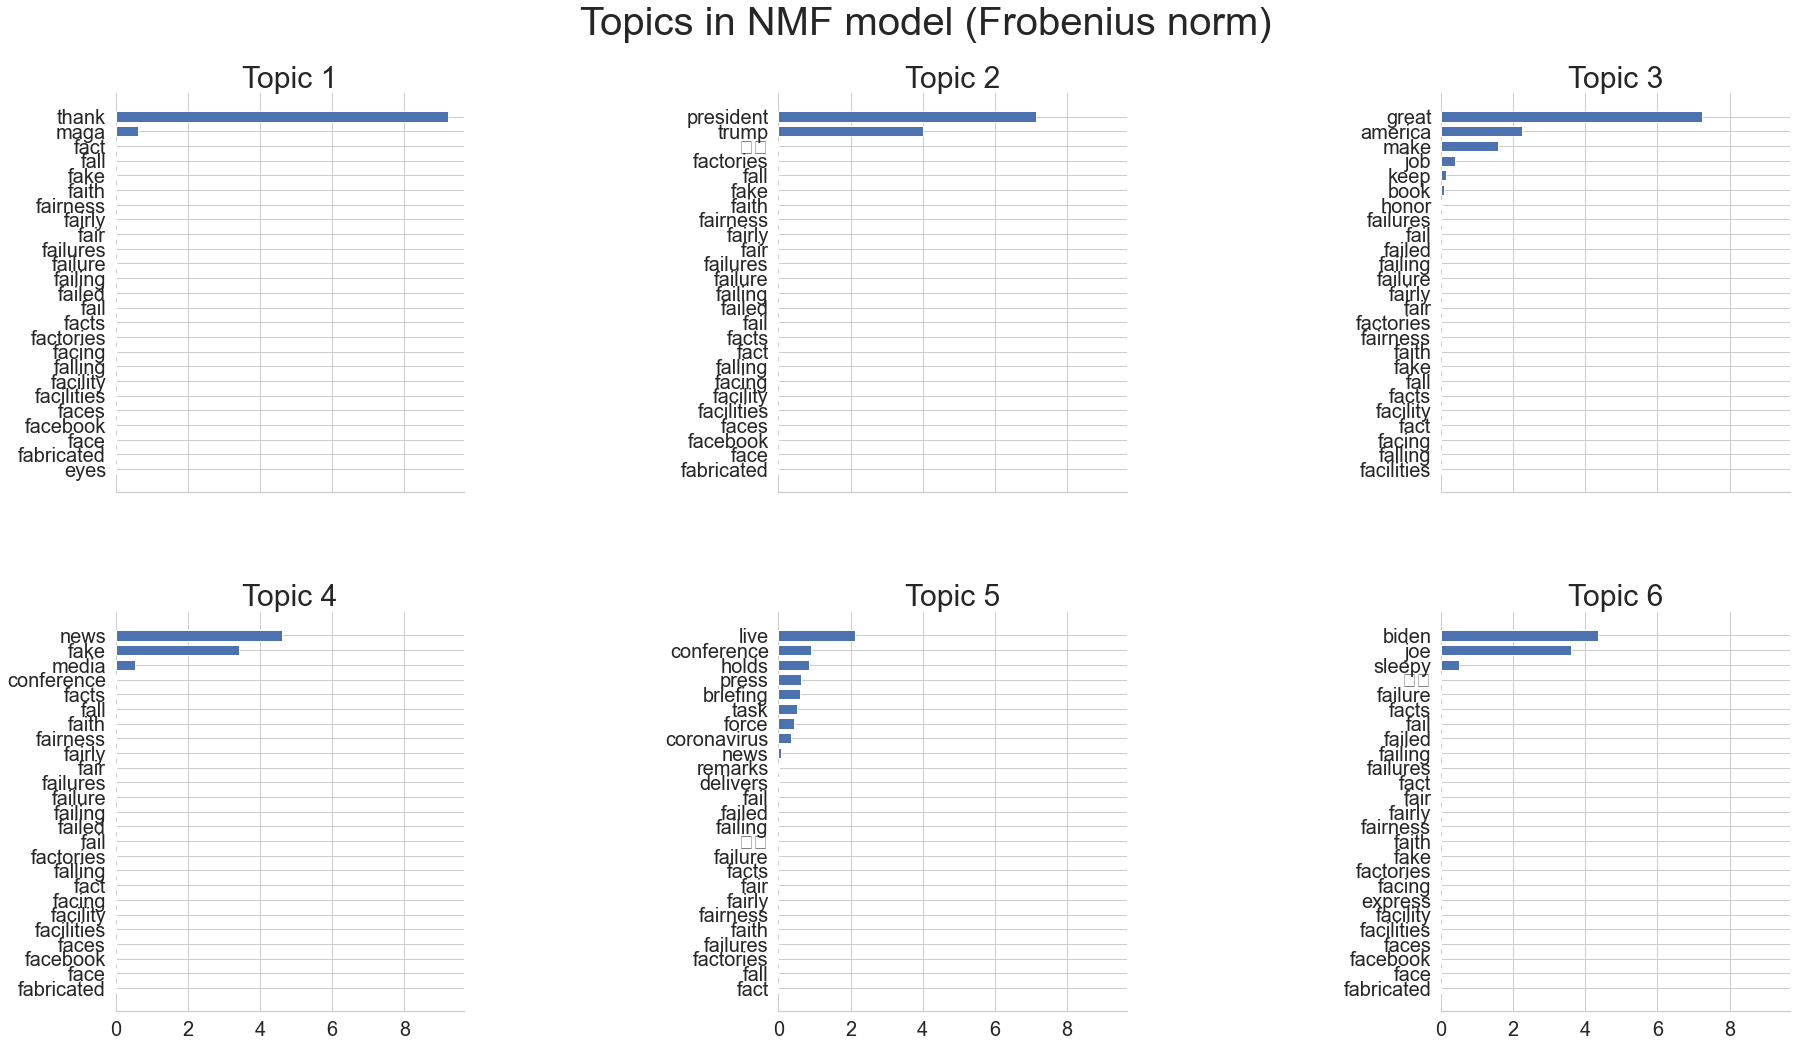

In [44]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_features=%d..." % (n_features, )
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_features=4000...
done in 6.223s.


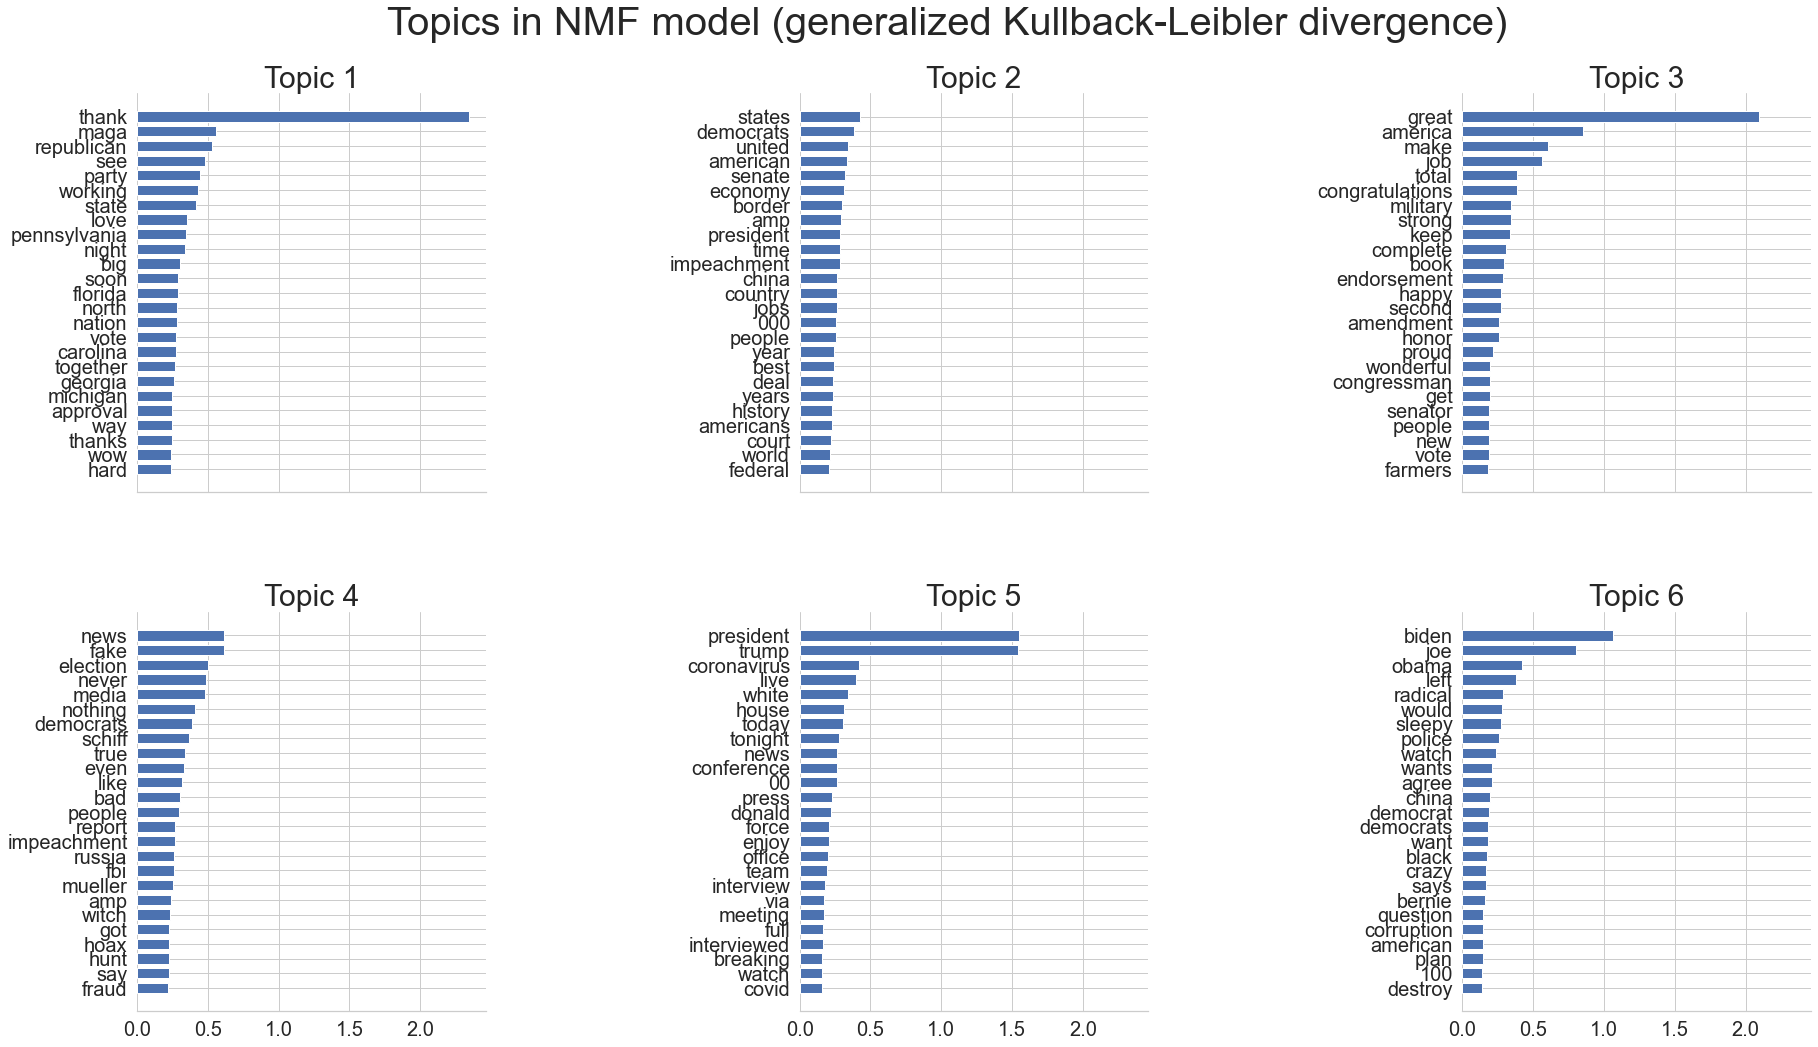

In [45]:
# Fit the NMF model
print(
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_features=%d..."
    % (n_features, ),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

Fitting LDA models with tf features, n_features=4000...
done in 38.297s.


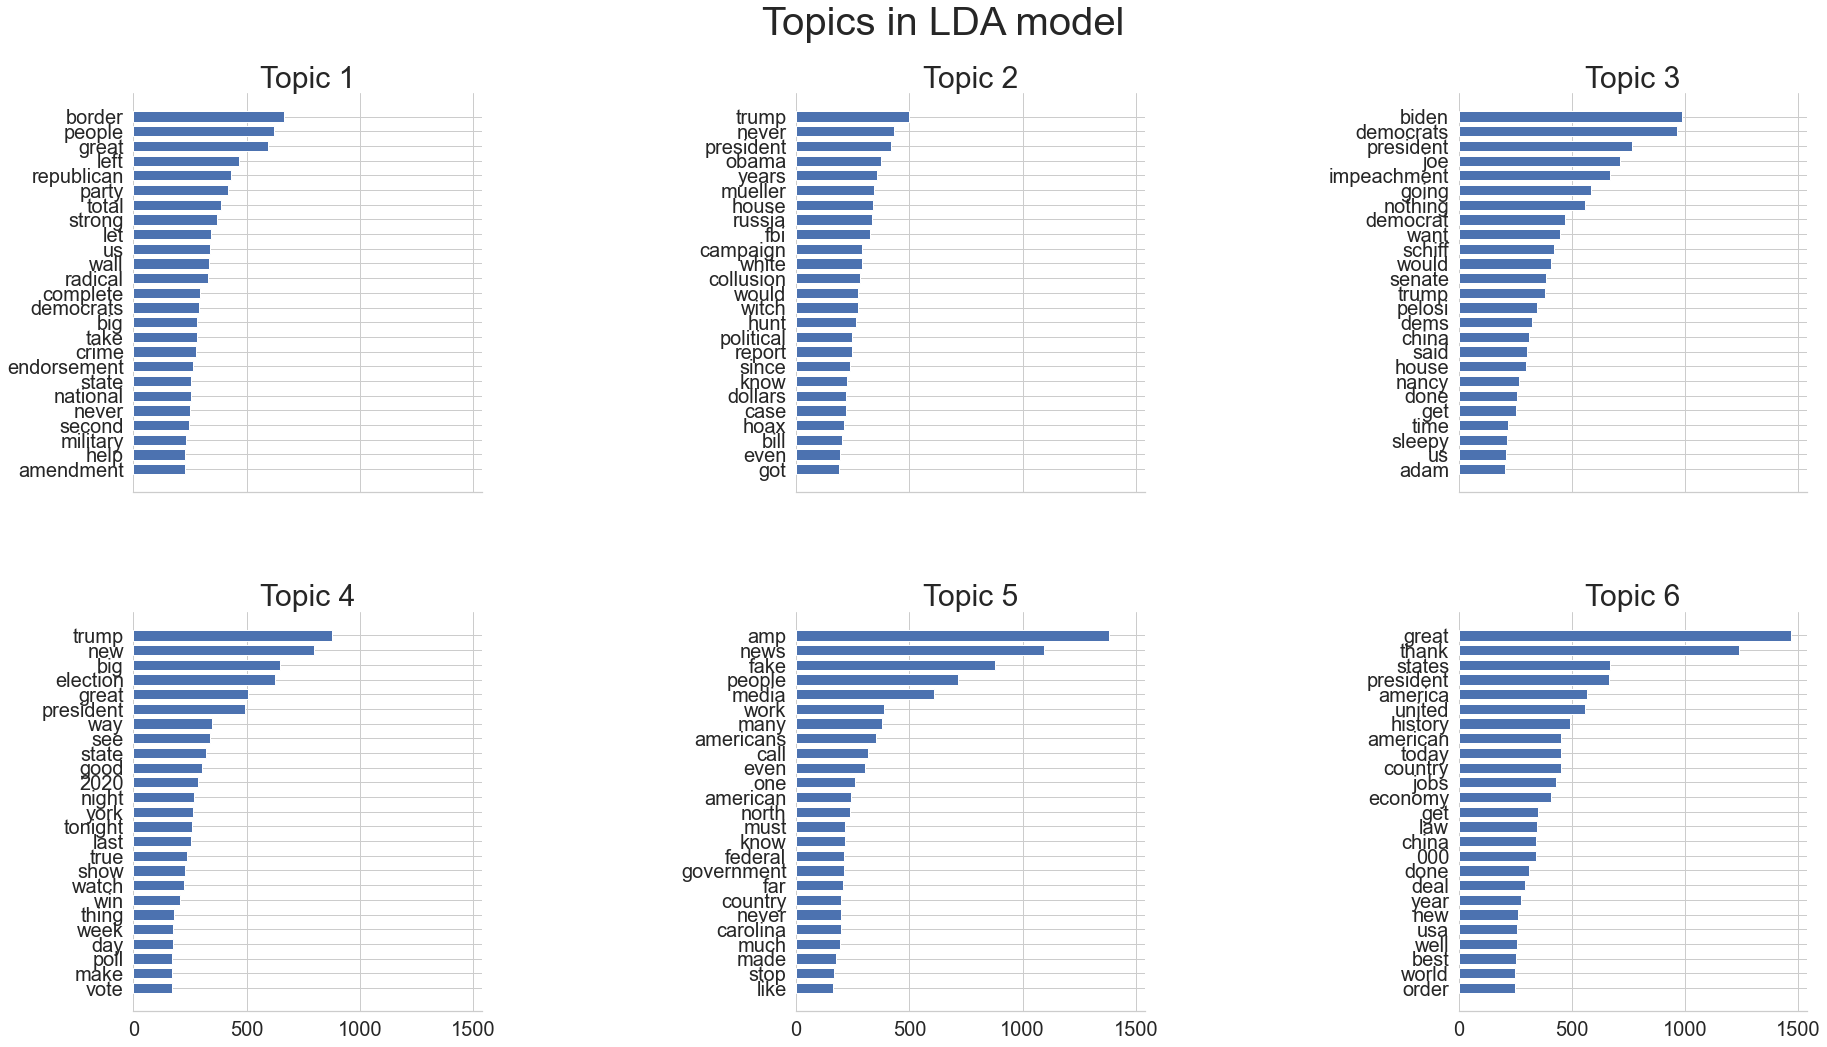

In [46]:
print(
    "Fitting LDA models with tf features, n_features=%d..."
    % (n_features, ),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=10,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [51]:
topic_names = {
    1: 'General',
    2: 'US president',
    3: 'Democrats',
    4: 'Trump election',
    5: 'Fake news',
    6: 'Great america',
}

In [52]:
tweets_topics_df = pd.DataFrame(
    data=lda.transform(tf), 
    columns=[topic_names.get(n, f'Topic {n}') for n in range(1, n_components+1)], 
    index=tweets_df.index
)
tweets_topics_df['date'] = pd.to_datetime(tweets_df.date).dt.to_period('w').dt.to_timestamp()
tweets_topics_df.head()

,General,US president,Democrats,Trump election,Fake news,Great america,date
id,,,,,,,
1234653427789070336,0.006976,0.006951,0.007093,0.006953,0.610498,0.361529,2020-03-02
1218010753434820608,0.016667,0.316697,0.116657,0.016685,0.116660,0.416634,2020-01-13
1304875170860015616,0.005760,0.109390,0.005790,0.005797,0.867507,0.005756,2020-09-07
1218159531554897920,0.018519,0.906447,0.019339,0.018519,0.018658,0.018519,2020-01-13
1217962723234983936,0.200751,0.015228,0.015246,0.440808,0.015165,0.312802,2020-01-13


In [53]:
plot_data = tweets_topics_df.groupby('date').mean()

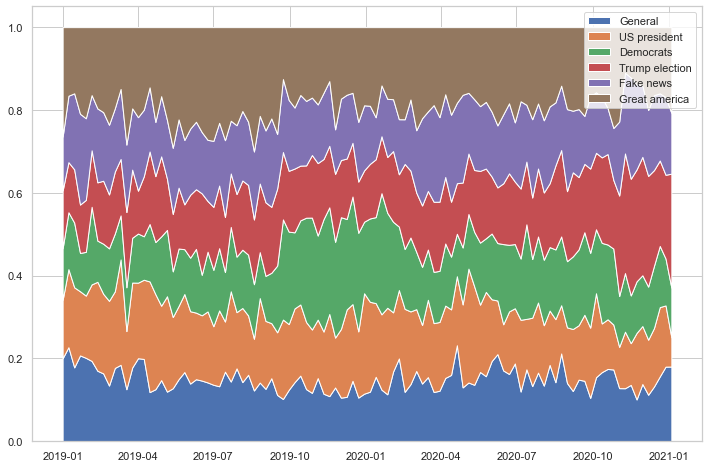

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))
labels, data = list(), list()
for label, single_data in plot_data.iteritems():
    labels.append(label)
    data.append(single_data)
    
plt.stackplot(
    plot_data.index,
    *data,
    labels=labels,
);
plt.legend(loc='upper right');